In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

LOWEST_YEAR = 1988 # This is the lowest year available in Dataset
HIGHEST_YEAR = 2016 # This is the highest year available in Dataset
START_YEAR = 2000
END_YEAR = 2017 # We're using 2017 because range() functions are exclusive for the last value

In [3]:
data = pd.read_csv('./commodity_trade_statistics_data.csv')

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
is_export = data['flow'] == 'Export'
is_live_animals = data['category'] == '01_live_animals'

country_summary_data = data[(data['country_or_area'] == 'USA') & is_export & is_live_animals][['year', 'trade_usd']].groupby('year').sum()

In [5]:
country_summary_data.head(5)

,trade_usd
year,
1991,692654489
1992,637981181
1993,522006551
1994,590751118
1995,544131807


In [6]:
country_summary_data.index.sort_values()[0] # First
country_summary_data.index.sort_values()[-1] # Last
country_summary_data.index.sort_values()[-2:] # Last two
country_summary_data.index.sort_values()[:-2] # All but last two

all_data = country_summary_data.sort_index()['trade_usd'].astype('float').values
train_data = all_data[:-1] # All data excluding last year
actual = all_data[-1:] # Only last year

In [7]:
model = ARMA(train_data, order=(0, 1))
model_fit = model.fit()
predicted = model_fit.predict(len(train_data), len(train_data))

In [8]:
countries = data[is_export & is_live_animals]['country_or_area'].unique()

In [9]:
# Make a dataset where index is countries names and columns will be predictions from different models

countries_df = pd.DataFrame(index=countries)

In [10]:
# Prediction algorithms

prediction_algorithms = {
    'autoregression':  AR(train_data),
    'arma': ARMA(train_data, order=(0, 1)),
    'arima': ARIMA(train_data, order=(1, 1, 1)),
    'sarimax': SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
}

In [11]:
for k, model in prediction_algorithms.items():
    print("Training algorigthm: " + k)
    model_fit = model.fit()
    predicted = model_fit.predict(len(train_data), len(train_data))
    
    diff = actual - predicted
    
    print("Predicted: " + str(predicted[0]) + ", Actual: " + str(actual[0]) + ", Diff: " + str(diff[0]))


Training algorigthm: autoregression
Predicted: 740520393.0744236, Actual: 784223079.0, Diff: 43702685.92557645
Training algorigthm: arma
Predicted: 711851159.9990355, Actual: 784223079.0, Diff: 72371919.00096452
Training algorigthm: arima
Predicted: 31160910.38336785, Actual: 784223079.0, Diff: 753062168.6166321
Training algorigthm: sarimax
Predicted: 783464871.6479359, Actual: 784223079.0, Diff: 758207.3520641327


/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


# Try ANN

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [13]:
TRAIN_SIZE = 20

In [14]:
len(all_data)

26

In [15]:
all_data_df = pd.DataFrame(all_data, columns=['X'])

In [16]:
train = all_data_df[:TRAIN_SIZE] # First 20 samples for training
test = all_data_df[TRAIN_SIZE:] # Last 20 samples for testing

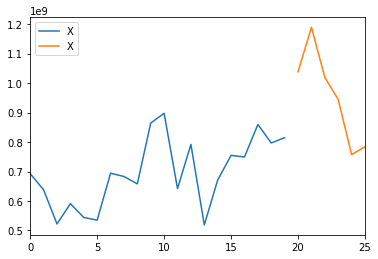

In [17]:
ax = train.plot()
test.plot(ax=ax)

In [79]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [80]:
# Prepare training and test data. Idea is that X - 1 predicts Y (i.e previous value predicts next one)
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [91]:
nn_model = Sequential()
# nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1, input_dim=1))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

In [92]:
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
19/19 [==============================] - 1s 58ms/step - loss: 0.6394
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6207
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6039
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5882
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5735
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5597
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5467
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5346
Epoch 9/100
19/19 [==============================] - 0s 1ms/step - loss: 0.5231
Epoch 10/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5124
Epoch 11/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5023
Epoch 12/100
19/19 [==============================] - 0s 2ms/step - loss: 0.4928
Epoch 13/100
19/19 [================

In [93]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.168
The R2 score on the Test set is:	0.063


In [94]:
nn_y_pred_test = nn_model.predict(X_test)

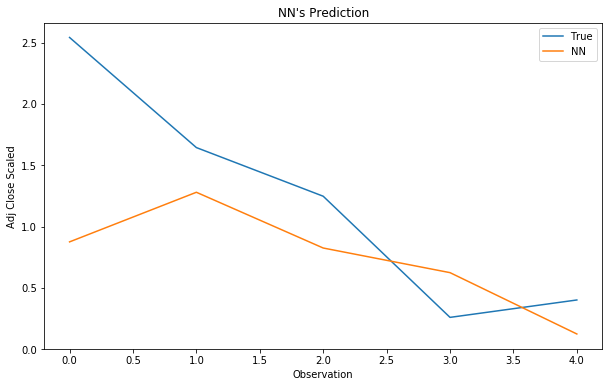

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("NN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

# Try LSTM

In [25]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)


In [26]:
for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

In [27]:
X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [28]:
print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (19, 1, 1)
Test shape:  (5, 1, 1)


In [29]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
19/19 [==============================] - 2s 101ms/step - loss: 0.4007
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.3957
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.3929
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.3902
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.3877
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.3852
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.3827
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.3803
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.3779
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.3755
Epoch 11/100
19/19 [==============================] - 0s 4ms/step - loss: 0.3731
Epoch 12/100
19/19 [==============================] - 0s 4ms/step - loss: 0.3708
Epoch 13/100
19/19 [===============

In [30]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.185
The R2 score on the Test set is:	-2.123


In [31]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

5/5 [==============================] - 0s 69ms/step
NN: 1.365759
LSTM: 2.198197


In [32]:
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

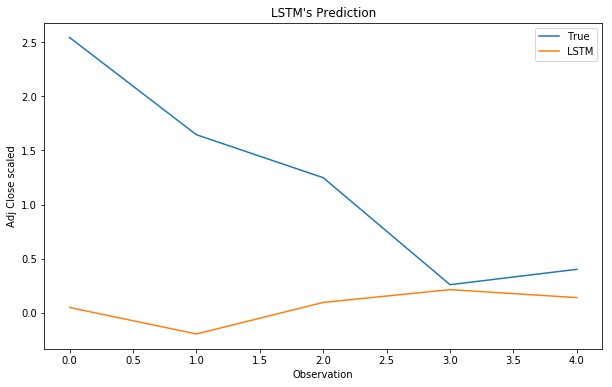

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();